In [ ]:
#opendataset is a library to downlaod kaggle datasets by providing the username and key for colab
!pip install opendatasets
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/kazanova/sentiment140'
od.download(dataset_url)

#key for kaggle
{"username":"name","key":"key"}

In [ ]:
#imports
import tqdm
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
DATASET_ENCODING = "ISO-8859-1"
DECODE_MAP = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
DATASET_SIZE = 1400000
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [ ]:
#read dataset
df = pd.read_csv('/content/sentiment140/training.1600000.processed.noemoticon.csv', encoding = DATASET_ENCODING, names =["target", "ids", "date", "flag", "user", "text"])
df = df.drop(['ids','date','flag','user'],axis = 1)

In [ ]:
df.head(-5)

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599990,4,WOOOOO! Xbox is back
1599991,4,@rmedina @LaTati Mmmm That sounds absolutely ...
1599992,4,ReCoVeRiNg FrOm ThE lOnG wEeKeNd
1599993,4,@SCOOBY_GRITBOYS


In [ ]:
#divides the dataset into positve and negetive
len_posistive = len(df[df['target']==4])
len_negetive  = len(df[df['target']==0])

negetive_df = df.loc[0:DATASET_SIZE/2]
positive_df = df.loc[len_posistive:len_posistive + (DATASET_SIZE/2)]

positive_df = positive_df.reset_index(drop=True)
negetive_df = negetive_df.reset_index(drop=True)

#concatenate positve and negetive dataset for training purpose
data = pd.concat([positive_df, negetive_df], ignore_index=True)

In [ ]:
#use of nltk for downloading stopwords
nltk.download('stopwords')
stop_words = stopwords.words("english")

#to simplify words to base words eg. (liked , liking , likes , likabele ) => like
stemmer = SnowballStemmer("english")

#to preprocess the text data => lower , substitute ,stemming
def preprocess(text,stem =False):
    text = re.sub(TEXT_CLEANING_RE, ' ' , str(text).lower()).strip()
    tokens= []
    for word in text.split():
        if word not in stop_words:
            if stem:
                tokens.append(stemmer.stem(word))
            else:
                tokens.append(word)

    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#apply preprocess on data
data.text = data.text.apply(lambda x : preprocess(x))
data.text

0                         love health4uandpets u guys r best
1          im meeting one besties tonight cant wait girl ...
2          thanks twitter add sunisa got meet hin show dc...
3          sick really cheap hurts much eat real food plu...
4                                            effect everyone
                                 ...                        
1399997                    wishes could see abt romeo juliet
1399998              heart burn day thats normal 14 year old
1399999                                            get blowd
1400000    hahahahah nothing ugh eye watery dont know soo...
1400001    people tweeting advice combat tear gas iran ir...
Name: text, Length: 1400002, dtype: object

In [ ]:
#break the words into list and append to sentences
sentences = []
for i in data['text']:
    sentences.append(i.split())

In [ ]:
# Train the model
#this will make a
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1,epochs=50)
# Save the model
w2v_model.save('word2vec.model')

In [ ]:
#load the model if already trained.
model = Word2Vec.load('/content/word2vec.model')

In [ ]:
index_to_key = model.wv.index_to_key #contains the list of  keys
vocab_size  = len(index_to_key)  + 1 #total lenght of vocab +1 is for pad 0

#model.wv wil conatain a matrix of length_vocab X vector_size
eg_ = model.wv['hello'] #shape => (100,)
#print(eg_.shape) #shape of one word
similar_words = model.wv.most_similar('bad', topn=5)
similar_words

[('good', 0.7588441371917725),
 ('horrible', 0.7193538546562195),
 ('terrible', 0.7140897512435913),
 ('awful', 0.6843911409378052),
 ('shitty', 0.6488863825798035)]

In [ ]:
vocab = index_to_key

In [ ]:
# Create a mapping from words to indices
word_to_index = {}
index_to_word = {}
for i, word in enumerate(vocab):
  word_to_index[word] = i
  index_to_word[i] = word

# creating a mapping for word to indices in sentences
max_length = 10
sequennces = []
for sentence in sentences:
  sequennces.append([word_to_index[word] for word in sentence])
print('1st sequences:', sequennces[0])

#padding of sequences
padded_sequences = pad_sequences(sequennces, maxlen=10, padding='pre') #=>maximum length of text to be 10 and padding is pre
print('Shape of padded sequences:', padded_sequences.shape)

1st sequences: [9, 127695, 14, 116, 222, 89]
Shape of padded sequences: (1400002, 10)


In [ ]:
#labes are encoded with 1  = positive and 0 = negetive
encoder = LabelEncoder()
encoder.fit(data.target.tolist())

Y = encoder.transform(data.target.tolist())
Y = Y.reshape(Y.shape[0],1)

print("shape of Y : " ,Y.shape)

shape of Y :  (1400002, 1)


In [ ]:
Y[1]

array([1])

In [ ]:

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()
device

device(type='cuda')

In [ ]:
#create a dataset class for loading data for further use of pytorch dataloader
from torch.utils.data import Dataset, DataLoader,random_split
import torch
class SentimentDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.LongTensor(data)
        self.labels = torch.LongTensor(labels).float()
        #self.labels = F.one_hot(torch.LongTensor(labels)).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [ ]:
'''creates the dataset for traning and validation '''

data = SentimentDataset(padded_sequences,Y)
batch_size = 128
# split the dataset for train and validation
train_dl , val_dl = random_split(data , [DATASET_SIZE-50000,50002])
train_dl = DataLoader(train_dl,batch_size = 128,shuffle = True,drop_last=True)  # shape of every bactch => (128 X 8)
val_dl = DataLoader(val_dl,batch_size = batch_size,shuffle = True,drop_last=True)

#creating weights for pretrained embedding layer
embedding_matrix = torch.FloatTensor(model.wv.vectors) #shape => (vocab_size, 100)

In [ ]:
#tranfering to device(gpu)
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)
embedding_matrix = to_device(embedding_matrix, device)

In [ ]:
"shape of embedding matrix " ,embedding_matrix.shape

('shape of embedding matrix ', torch.Size([306458, 100]))

In [ ]:
for a , b in train_dl:
    print(a[0],b[0])
    break

tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0, 673], device='cuda:0') tensor([0.], device='cuda:0')


In [ ]:
''' creating the model  RNN'''

class RNN_Sentiment_Analysis(nn.Module):
    def __init__(self,embedding_matrix,hidden_size):

        super(RNN_Sentiment_Analysis,self).__init__()

        #create embedding layer , freeze the weights that are pretrained
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)

        #define RNN layeer
        self.rnn = nn.RNN(input_size=embedding_matrix.shape[1],hidden_size=hidden_size, batch_first=True)

        #define linear layer with input_size = hidde_size(RNN) output_size = 2
        self.linear = nn.Linear(256,2)

        #softmax layer will give 2d ouput
        self.softmax = nn.Softmax(dim=1)

    def forward(self,x):
        embd =  self.embedding(x)
        output , hidden   = self.rnn(embd)
        fc = self.linear(hidden.squeeze_(0)) #shape =>(128 x hidden_size)
        out = self.softmax(fc)
        return out

RNN_model = RNN_Sentiment_Analysis(embedding_matrix,256)
RNN_model = to_device(RNN_model,device)

lr=0.005
# define adam optimizer
optimizer = torch.optim.Adam(RNN_model.parameters(), lr=lr)

#define evaluation model , returns average (accuracy , loss) of validation data
def eval(model , val_dl):
    model.eval()
    accuracies = []
    losses = []
    for data, labels in tqdm.tqdm(val_dl):
        output = model(data)
        _,preds = torch.max(output,dim=1)
        _,labels =  torch.max(labels.squeeze(1),dim=1)
        accuracies.append(torch.tensor(torch.sum(preds==labels).item()/len(preds)).item())
        loss = F.cross_entropy(label.squeeze(1),label_pred).item()
        losses.append(loss)
    return sum(accuracies)/len(accuracies) , sum(losses)/len(losses)



losses = []
val_accuracies = []
val_losses = []
epochs = 15

import tqdm

for epoch in range(epochs):
    RNN_model.train()
    for i,(text,label) in tqdm.tqdm(enumerate(train_dl)):
        optimizer.zero_grad()
        label_pred = RNN_model(text)
        loss = F.cross_entropy(label.squeeze(1),label_pred)
        loss.backward()
        optimizer.step()
    print("VALIDATING .....")
    val_acccuracy, val_loss  = eval(RNN_model,val_dl)
    print(f"EPOCH {epoch}/{epochs} || TRAINING LOSS : {loss} || VALIDATION LOSS : {val_loss} || VALIDATION ACCURACY : {val_acccuracy}")
    losses.append(loss.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acccuracy)

In [ ]:
''' creating the model  LSTM'''

class RNN_Sentiment_Analysis(nn.Module):
    def __init__(self,embedding_matrix,hidden_size):

        super(RNN_Sentiment_Analysis,self).__init__()

        #create embedding layer , freeze the weights that are pretrained
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)

        #define RNN layeer
        self.rnn = nn.LSTM(input_size=embedding_matrix.shape[1],hidden_size=hidden_size, batch_first=True)

        #define linear layer with input_size = hidde_size(RNN) output_size = 2
        self.linear = nn.Linear(256,2)

        #softmax layer will give 2d ouput
        self.softmax = nn.Softmax(dim=1)

    def forward(self,x):
        embd =  self.embedding(x)
        output , hidden   = self.rnn(embd)
        fc = self.linear(hidden[0].squeeze_(0)) #shape =>(128 x hidden_size)
        out = self.softmax(fc)
        return out

RNN_model = RNN_Sentiment_Analysis(embedding_matrix,256)
RNN_model = to_device(RNN_model,device)

lr=0.005
# define adam optimizer
optimizer = torch.optim.Adam(RNN_model.parameters(), lr=lr)

#define evaluation model , returns average (accuracy , loss) of validation data
def eval(model , val_dl):
    model.eval()
    accuracies = []
    losses = []
    for data, labels in tqdm.tqdm(val_dl):
        output = model(data)
        _,preds = torch.max(output,dim=1)
        _,labels =  torch.max(labels.squeeze(1),dim=1)
        accuracies.append(torch.tensor(torch.sum(preds==labels).item()/len(preds)).item())
        loss = F.cross_entropy(label.squeeze(1),label_pred).item()
        losses.append(loss)
    return sum(accuracies)/len(accuracies) , sum(losses)/len(losses)



losses = []
val_accuracies = []
val_losses = []
epochs = 15

import tqdm

for epoch in range(epochs):
    RNN_model.train()
    for i,(text,label) in tqdm.tqdm(enumerate(train_dl)):
        optimizer.zero_grad()
        label_pred = RNN_model(text)
        loss = F.cross_entropy(label.squeeze(1),label_pred)
        loss.backward()
        optimizer.step()
    print("VALIDATING .....")
    val_acccuracy, val_loss  = eval(RNN_model,val_dl)
    print(f"EPOCH {epoch}/{epochs} || TRAINING LOSS : {loss} || VALIDATION LOSS : {val_loss} || VALIDATION ACCURACY : {val_acccuracy}")
    losses.append(loss.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acccuracy)

In [ ]:
''' creating the model  LSTM with bce'''

class RNN_Sentiment_Analysis(nn.Module):
    def __init__(self,embedding_matrix,hidden_size):

        super(RNN_Sentiment_Analysis,self).__init__()

        #create embedding layer , freeze the weights that are pretrained
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)

        #define RNN layeer
        self.rnn = nn.LSTM(input_size=embedding_matrix.shape[1],hidden_size=hidden_size, batch_first=True)

        #define linear layer with input_size = hidde_size(RNN) output_size = 2
        self.linear = nn.Linear(256,1)

        #softmax layer will give 2d ouput
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        embd =  self.embedding(x)
        output , hidden   = self.rnn(embd)
        fc = self.linear(hidden[0].squeeze_(0)) #shape =>(128 x hidden_size)
        out = self.sigmoid(fc)
        return out

RNN_model = RNN_Sentiment_Analysis(embedding_matrix,256)
RNN_model = to_device(RNN_model,device)

lr=0.005
# define adam optimizer
optimizer = torch.optim.Adam(RNN_model.parameters(), lr=lr)

#define evaluation model , returns average (accuracy , loss) of validation data
def eval(model , val_dl):
    model.eval()
    accuracies = []
    losses = []
    for data, labels in tqdm.tqdm(val_dl):
        output = model(data)
        predictions = (output >= 0.5).int()
        correct_predictions = (predictions == labels).sum().item()
        accuracy = correct_predictions / len(labels)
        loss = F.binary_cross_entropy(labels,output).item()
        losses.append(loss)
    return accuracy, sum(losses)/len(losses)


losses = []
val_accuracies = []
val_losses = []
epochs = 15
import tqdm

for epoch in range(epochs):
    RNN_model.train()
    for i,(text,label) in tqdm.tqdm(enumerate(train_dl)):
        optimizer.zero_grad()
        label_pred = RNN_model(text)
        loss = F.binary_cross_entropy(label,label_pred)
        loss.backward()
        optimizer.step()
    print("VALIDATING .....")
    val_acccuracy, val_loss  = eval(RNN_model,val_dl)
    print(f"EPOCH {epoch}/{epochs} || TRAINING LOSS : {loss} || VALIDATION LOSS : {val_loss} || VALIDATION ACCURACY : {val_acccuracy}")
    losses.append(loss.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acccuracy)


In [ ]:
def predict(text,model):
    decode_map = {0: "NEGATIVE", 1: "POSITIVE"}
    text = preprocess(text)
    model.eval()
    sequence = [word_to_index[i] for i in text.split()]
    padded_sequence = torch.LongTensor(pad_sequences([sequence], maxlen=10, padding='pre'))
    padded_sequence = to_device(padded_sequence, device)
    output = model(padded_sequence)
    print(output)
    _ , output = torch.max(output,dim=1)
    print(decode_map[output.item()])


In [ ]:
text = 'hello i do not like what tyou are saying  '
predict(text,RNN_model)

In [ ]:
import csv
from datetime import datetime

def log_hyperparameters_to_csv(file_path, hyperparameters):
    """
    Log machine learning hyperparameters to a CSV file.

    Parameters:
    - file_path (str): The path to the CSV file.
    - hyperparameters (dict): A dictionary containing hyperparameters and their values.
    """
    # Get the current timestamp for logging purposes
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Open the CSV file in append mode
    with open(file_path, mode='a', newline='') as csv_file:
        # Create a CSV writer
        csv_writer = csv.writer(csv_file)

        # If the file is empty, write the header
        if csv_file.tell() == 0:
            header = ['Timestamp'] + list(hyperparameters.keys())
            csv_writer.writerow(header)

        # Create a row with timestamp and hyperparameter values
        row = [timestamp] + list(hyperparameters.values())

        # Write the row to the CSV file
        csv_writer.writerow(row)

# Example usage:
hyperparameters = {
    'learning_rate': lr,
    'batch_size': batch_size,
    'epochs': epochs,
    'optimizer': 'adam WITH BCE',
    'max_length' : max_length,
    'val_loss' : val_losses,
    'val_acccuracy' : val_accuracies,
    'training_loss' : loss,
    'dataset_size' : DATASET_SIZE,
    'model_sturcture' : ['embedding , LSTM , linear , softmax'],
    'input_size' : 100,
    'word_to_vec_epochs' : 50


}

log_hyperparameters_to_csv('hyperparameters_log.csv', hyperparameters)


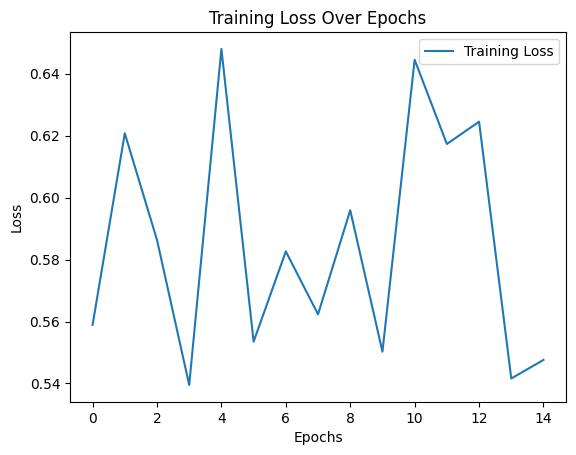

In [ ]:
import matplotlib.pyplot as plt


# Plotting the training losses
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


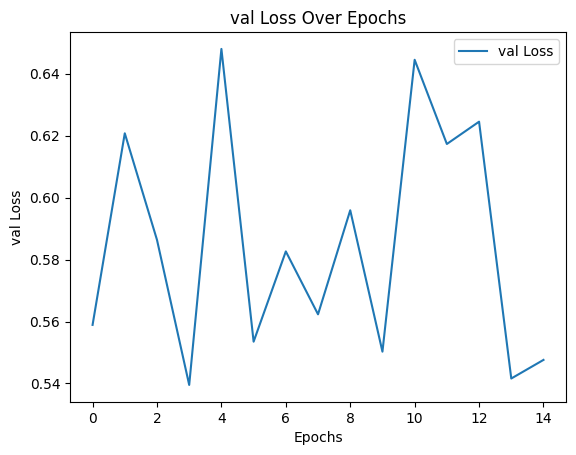

In [ ]:

# Plotting the training losses
plt.plot(val_losses, label='val Loss')
plt.xlabel('Epochs')
plt.ylabel('val Loss')
plt.title('val Loss Over Epochs')
plt.legend()
plt.show()


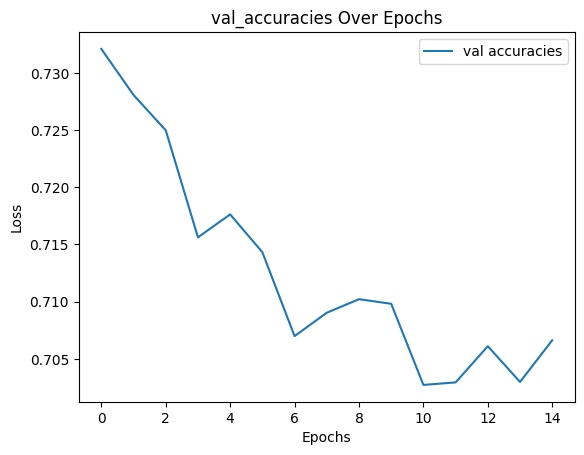

In [ ]:

# Plotting the training losses
plt.plot(val_accuracies, label='val accuracies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('val_accuracies Over Epochs')
plt.legend()
plt.show()